# 反向传播算法

请使用jupyter完成相关代码的运行。 若未安装该依赖，直接阅读该 pdf 文件同样可以获取练习结果。

---

## 模型与数据

![img](./img/1.png)

---

## 准备工作

### 导入依赖。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 

In [2]:
def sigmoid(z):
    '''
    sigmoid 函数
    Args:
        z (m, n): 输入
    Returns:
        g (m, n): sigmoid 函数输出
    '''
    d = 1 + np.exp(-z)
    return 1. / d

### Sigmoid函数的梯度的函数

In [3]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

### 前向传播函数

单隐层网络，注意偏置 b = 0。

In [4]:
def forward_propagate(X, theta1, theta2):
    '''
    前向传播函数
    Args:
        X (m, n): m个样本，n个特征
        theta1 (t, n): t个神经元
        theta2 (k, t): k个输出
    Returns:
        a1 (m, n)
        z2 (m, t)
        a2 (m, t)
        z3 (m, k)
        h (m, k)
    '''
    m = X.shape[0]

    # 激活项a, 线性输出z
    a1 = X
    z2 = a1 * theta1.T
    a2 = sigmoid(z2)
    z3 = a2 * theta2.T
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

### 代价函数

创建一个以参数θ为特征函数的代价函数
$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$
其中：\\[{{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

In [5]:
def cost(params, input_size, hidden_size, num_labels, X, y):
    '''
    代价函数
    Args:
        params (hidden_size * input_size + num_labels * hidden_size, ): 参数
        input_size (int): 输入的特征数
        hidden_size (int): 隐藏层的神经元数
        num_labels (int): 输出层神经元数/类别数
        X (m, n): m个样本，n个特征
        y (m, k): 需要拟合的值, k个类别
    Returns:
        cost (int): 代价
    '''
    m = X.shape[0]
    
    # 将参数数组重构为每一层的参数矩阵
    theta1 = np.reshape(params[:hidden_size * input_size], (hidden_size, input_size))
    theta2 = np.reshape(params[hidden_size * input_size:], (num_labels, hidden_size))
    
    # 前向传播
    _, _, _, _, h = forward_propagate(X, theta1, theta2)
    
    # 计算损失
    J = np.power(h - y, 2)
    cost = J.sum()/2/m

    return cost

### BP算法

扩展代价函数以执行反向传播并返回代价和梯度。

只需要循环迭代计算每一层每个节点的 δ, e ...等值即可求得当前层的偏导数,从而得到每层权值矩阵 W 的梯度,再通过梯度下降算法迭代优化网络参数即可。

![img](./img/2.png)

In [6]:
def backprop(params, input_size, hidden_size, num_labels, X, y):
    '''
    执行反向传播并返回代价和梯度
    Args:
        params (hidden_size * input_size + num_labels * hidden_size, ): 参数
        input_size (int): 输入的特征数
        hidden_size (int): 隐藏层的神经元数
        num_labels (int): 输出层神经元数/类别数
        X (m, n): m个样本，n个特征
        y (m, k): 真实值, k个类别
    Returns:
        cost (int): 代价
        grad (hidden_size * input_size + num_labels * hidden_size, ): 梯度
    '''
        
    m = X.shape[0]
    
    # 将参数数组重构为每一层的参数矩阵
    theta1 = np.matrix(np.reshape(params[:hidden_size * input_size], (hidden_size, input_size)))
    theta2 = np.matrix(np.reshape(params[hidden_size * input_size:], (num_labels, hidden_size)))
    
    # 前向传播
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # 计算损失
    J = np.power(h - y, 2)
    cost = J.sum()/2/m
    
    # 误差反向传播
    error3 = h - y
    delta3 = np.multiply(error3, sigmoid_gradient(z3)) 
    error2 = delta3 @ theta2
    delta2 = np.multiply(error2, sigmoid_gradient(z2))
    # 计算梯度  
    grad2 = delta3.T @ a2 / m 
    grad1 = delta2.T @ a1 / m
    
    # 将梯度矩阵分解成单个数组
    grad = np.concatenate((np.ravel(grad1), np.ravel(grad2)))
    
    return cost, grad

训练函数。

In [7]:
def train(X, y, params, input_size, hidden_size, num_labels, alpha, iters, step = -1):
    '''
    训练函数
    Args:
        X (m, n): m个样本，n个特征
        y (m, k): 真实值, k个类别
        params (hidden_size * input_size + num_labels * hidden_size, ): 参数
        input_size (int): 输入的特征数
        hidden_size (int): 隐藏层的神经元数
        num_labels (int): 输出层神经元数/类别数
        alpha (int): 学习率
        iters (int): 最大迭代次数
        step (int): 每组样本的数量
    Returns:
        g(1, n): 参数最终值
        cost(iters, 1): 代价函数历史值
    '''
    m = X.shape[0]
    g = params.copy()
    cost = np.matrix(np.zeros((iters, 1)))
    
    # 默认为批量
    if step == -1:
        step = m
    
    for i in range(iters):
        for j in range(0, m, step):
            Xs = X[j:j+step, :]
            ys = y[j:j+step]
            
            # 计算梯度和损失
            J, grad = backprop(g, input_size, hidden_size, num_labels, X, y)
            
            g = g - alpha * grad
            cost[i, 0] = J

    return g, cost

---

## 作业4

训练浅层 NN 解决 XOR 问题。

系数1:
 [[-1.43840345 -2.57850287 -0.59951949]
 [ 5.66912409 -6.46909792 -2.98745337]
 [ 5.904235   -4.71327075  2.02651503]
 [ 0.15486005  1.27992053  1.3908879 ]]
系数2: 
[[-1.94191418  8.9657461  -7.9632331   4.25257878]]
网络输出值: 
[[0.0200602 ]
 [0.96747408]
 [0.97616627]
 [0.03040378]]



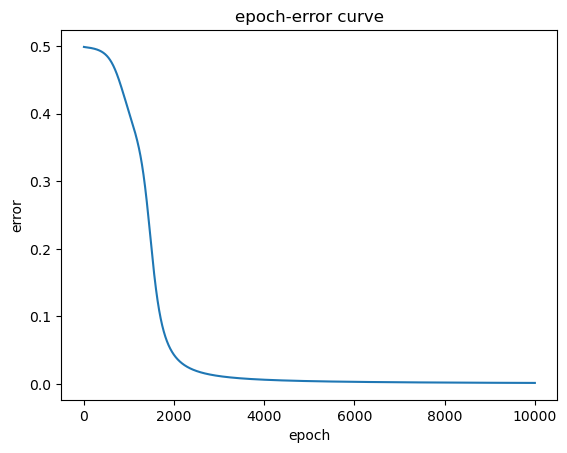

In [8]:
# 数据
X = np.array([[0, 0, 1],
             [0, 1, 1],
             [1, 0, 1],
             [1, 1, 1]])
y = np.array([0, 1, 1, 0])

m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y).T

# 初始化设置
input_size = 3
hidden_size = 4
num_labels = 1
alpha = 0.9
epoch = 10000

# 随机初始化完整网络参数大小的参数数组
params = np.random.random(size = hidden_size * input_size + num_labels * hidden_size) * 2 - 1

# 训练
thetas, cost = train(X, y, params, input_size, hidden_size, num_labels, alpha, epoch)

# 观察输出
theta1 = np.reshape(thetas[:hidden_size * input_size], (hidden_size, input_size))
theta2 = np.reshape(thetas[hidden_size * input_size:], (num_labels, hidden_size))
print(f"系数1:\n {theta1}\n系数2: \n{theta2}\n网络输出值: \n{forward_propagate(X, theta1, theta2)[-1]}\n")

# 绘制曲线
fig, ax = plt.subplots()
t = np.linspace(1, epoch, epoch)                # 创建t的取值范围
ax.plot(t, m * cost)                            # 作误差曲线

ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.set_title('epoch-error curve')

plt.show() 

---

## 作业5

尝试改变隐层节点个数(3、5、2? )。

观察能否解决XOR问题?

如何避免不收敛?

隐层节点个数: 3
系数1:
 [[-4.18166254 -7.14489607  0.29824602]
 [ 3.5675181   6.48387762  0.32958995]
 [-2.32086161  7.5832083   1.26041126]]
系数2: 
[[-4.73340388  4.67795666 -4.6736684 ]]
网络输出值: 
[[0.02564816]
 [0.49870035]
 [0.96398893]
 [0.50273115]]

隐层节点个数: 5
系数1:
 [[-4.55787273 -4.08789214  6.55420179]
 [ 0.88983252 -0.12138539  0.44866493]
 [ 0.93984584  0.5322498  -0.65003489]
 [-5.75979885 -6.08683695  2.40498726]
 [-1.00358538  2.14101103  0.97853529]]
系数2: 
[[ 8.38065816 -1.50438508 -1.63658538 -9.5987283  -2.40886527]]
网络输出值: 
[[0.02495128]
 [0.97174464]
 [0.97673698]
 [0.02855504]]

隐层节点个数: 2
系数1:
 [[-5.88401913  5.73966199 -3.14168374]
 [-7.27827899  7.27645832  1.28179167]]
系数2: 
[[ 8.96798948 -4.82547967]]
网络输出值: 
[[0.03211748]
 [0.97131385]
 [0.49727629]
 [0.03069894]]



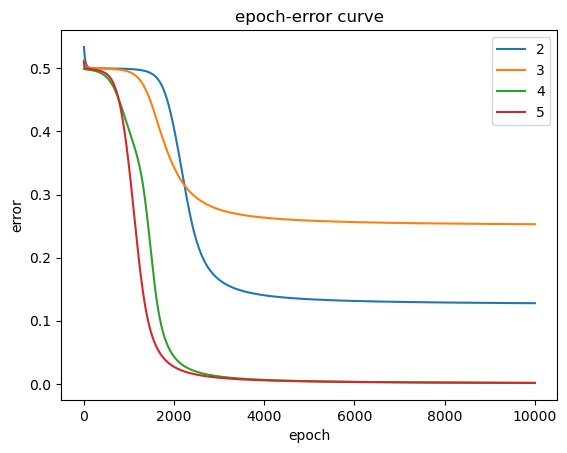

In [11]:
# 改变隐层节点个数并进行训练
hidden_size = 3
params = np.random.random(size = hidden_size * input_size + num_labels * hidden_size) * 2 - 1
thetas, cost3 = train(X, y, params, input_size, hidden_size, num_labels, alpha, epoch)
theta1 = np.reshape(thetas[:hidden_size * input_size], (hidden_size, input_size))
theta2 = np.reshape(thetas[hidden_size * input_size:], (num_labels, hidden_size))
print(f"隐层节点个数: 3\n系数1:\n {theta1}\n系数2: \n{theta2}\n网络输出值: \n{forward_propagate(X, theta1, theta2)[-1]}\n")

hidden_size = 5
params = np.random.random(size = hidden_size * input_size + num_labels * hidden_size) * 2 - 1
thetas, cost5 = train(X, y, params, input_size, hidden_size, num_labels, alpha, epoch)
theta1 = np.reshape(thetas[:hidden_size * input_size], (hidden_size, input_size))
theta2 = np.reshape(thetas[hidden_size * input_size:], (num_labels, hidden_size))
print(f"隐层节点个数: 5\n系数1:\n {theta1}\n系数2: \n{theta2}\n网络输出值: \n{forward_propagate(X, theta1, theta2)[-1]}\n")

hidden_size = 2
params = np.random.random(size = hidden_size * input_size + num_labels * hidden_size) * 2 - 1
thetas, cost2 = train(X, y, params, input_size, hidden_size, num_labels, alpha, epoch)
theta1 = np.reshape(thetas[:hidden_size * input_size], (hidden_size, input_size))
theta2 = np.reshape(thetas[hidden_size * input_size:], (num_labels, hidden_size))
print(f"隐层节点个数: 2\n系数1:\n {theta1}\n系数2: \n{theta2}\n网络输出值: \n{forward_propagate(X, theta1, theta2)[-1]}\n")

# 绘制曲线
fig, ax = plt.subplots()
t = np.linspace(1, epoch, epoch)                # 创建t的取值范围
ax.plot(t, m * cost2, label='2')               # 作误差曲线
ax.plot(t, m * cost3, label='3') 
ax.plot(t, m * cost, label='4') 
ax.plot(t, m * cost5, label='5') 

ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.set_title('epoch-error curve')
ax.legend()

plt.show() 

多次实验可发现。

隐层节点数为 2、3 时，训练效果不佳。

隐层节点数越多，损失随着轮次的增加下降越快。

隐层节点数大于等于 4 时，可以解决 XOR 问题。

增加隐层节点数，可以避免不收敛。